In [1]:
import datetime
from pathlib import Path
from netCDF4 import Dataset
from time import strftime,localtime
import numpy as np
createVar = locals()

In [2]:
ii=1
item=['Solar-Radiation-Flux','Temperature-Air-2m-Min-24h','Temperature-Air-2m-Max-24h', \
       'Vapour-Pressure-Mean', 'Wind-Speed-10m-Mean', 'Precipitation-Flux'][ii]
s_item=["rad","tmin","tmax","hum","wind","prec"][ii]
input_path = 'D:/hh/weather'
output_path = 'D:/hh/weather/AgERA5_NC_10_10_grid/temp'
Path(output_path).mkdir(parents=True, exist_ok=True)

parnames = {"rad","tmin","tmax","hum","wind","prec"}
long_name_dict=dict(hum="vapour pressure",rad="irradiation",tmax="maximum temperature",
                    tmin="minimum temperature",wind="mean wind speed",prec="precipitation")
units_dict=dict(hum="kPa",rad="kJ m-2 d-1",tmax="degrees Celsius",
                    tmin="degrees Celsius",wind="m s-1",prec="mm d-1")
dataset_attrs={"Conventions"}
lon_lat_attrs={"standard_name","long_name","units","axis"}
src_file = Path(input_path) / ('2020/%s'%item) / ('%s_C3S-glob-agric_AgERA5_20200101_final-v1.0.nc'%item)
src_dataset = Dataset(src_file, autoscale=True)

mask_path = Path(input_path) / 'mask_CMFD_V0106_B-01_010deg.nc'
mask_dataset =  Dataset(mask_path, autoscale=True)
mask_data = mask_dataset['mask'][0,:,:][::-1,] #mask数据纬度排序与此相反

for y in range(0,1800,10):
    for x in range(0,3600,10):
        lat,lon = 90-y/10., -180+x/10. #[90,-90],[-180,180],mask数据纬度排序与此相反

        if (y-351<0) or (x-2500<0) or(y-351>=400) or (x-2500>=700):
            continue
        if np.sum(mask_data[y-351:y-341,x-2500:x-2490])==0: #中国大陆相对位置
            continue
        print('.',end='')
        
        data_path = Path(output_path) / ('%s_%03d_%03d.nc'%(s_item,lon,lat))
        with Dataset(data_path,"w", format="NETCDF4") as weather_dataset:
            #复制/增加dataset的属性
            for attr in dataset_attrs:
                weather_dataset.__setattr__(attr,src_dataset.__getattribute__(attr))
            weather_dataset.notes="Reorganized by Huang Hai for WOFOST at %s"%strftime("%Y-%m-%d %H:%M:%S", localtime())
            #创建维度
            weather_dataset.createDimension("time",None) 
            weather_dataset.createDimension("lon",10)
            weather_dataset.createDimension("lat",10)
            #创建变量
            times = weather_dataset.createVariable('time', np.float64, ('time',))
            lons = weather_dataset.createVariable('lon', np.float32, ('lon',))
            lats = weather_dataset.createVariable('lat', np.float32, ('lat',))
            temps= weather_dataset.createVariable(s_item, np.float32,('time','lat','lon'))
            #重新设定times的单位
            times.units = "days since 1900-01-01"
            times.calendar = "proleptic_gregorian"
            #赋值经纬度的属性
            for attr in lon_lat_attrs:
                lons.__setattr__(attr,src_dataset.variables["lon"].__getattribute__(attr))
                lats.__setattr__(attr,src_dataset.variables["lat"].__getattribute__(attr))            
 
            temps.long_name=long_name_dict[s_item]
            temps.units=units_dict[s_item]

            times[:]=np.arange(40177,44194+1,1) #2010-2020
            lons[:]=src_dataset.variables["lon"][x:x+10]
            lats[:]=src_dataset.variables["lat"][y:y+10]
            
            nd=0
            for year in range(2010,2021):
                if (year % 4) == 0 and (year % 100) != 0 or (year % 400) == 0:
                    numdays = 366
                else:
                    numdays = 365
                for d in range(numdays):
                    date=datetime.date(year,1,1)+datetime.timedelta(d)
                    file_path = Path(input_path) / ('%d/%s'%(year,item)) / \
                                ('%s_C3S-glob-agric_AgERA5_%d%02d%02d_final-v1.0.nc'%(item,year,date.month,date.day))
                    temp_dataset = Dataset(file_path, autoscale=True)
                    temp_data = temp_dataset.variables[item.replace('-','_')][0,y:y+10,x:x+10] 
                    if item.startswith('Temperature'): 
                        temp_data -= 273.15
                    elif item=='Solar-Radiation-Flux':
                        temp_data = temp_data/1000.
                    elif item=='Vapour-Pressure-Mean':
                         temp_data = temp_data/10.
                    else:
                        pass
                    temps[nd,:,:]=temp_data
                    temp_dataset.close()
                    nd+=1
     
print ('succeed!')               
                

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

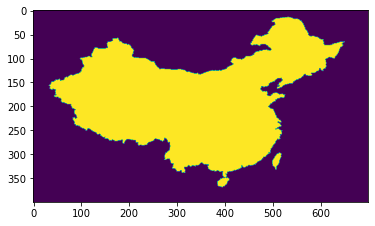

In [91]:
import matplotlib.pyplot as plt
plt.imshow(mask_data[::-1,])

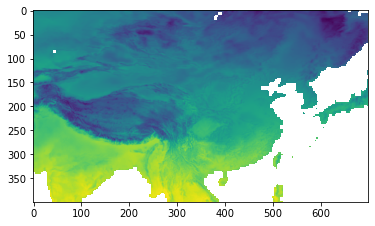

In [98]:
plt.imshow(src_dataset.variables["Temperature_Air_2m_Max_24h"][0,351:751,2500:3200])

In [103]:
file_path = Path(input_path) / ('%d/Temperature-Air-2m-Max-24h'%2010) / \
            ('Temperature-Air-2m-Max-24h_C3S-glob-agric_AgERA5_%d%02d%02d_final-v1.0.nc'%(2010,1,1))
tmax_dataset = Dataset(file_path, autoscale=True)

In [100]:
src_dataset.variables["lat"][y:y+10]

masked_array(data=[53. , 52.9, 52.8, 52.7, 52.6, 52.5, 52.4, 52.3, 52.2,
                   52.1],
             mask=False,
       fill_value=1e+20)

In [101]:
src_dataset.variables["lon"][x:x+10]

masked_array(data=[126. , 126.1, 126.2, 126.3, 126.4, 126.5, 126.6, 126.7,
                   126.8, 126.9],
             mask=False,
       fill_value=1e+20)

In [104]:
tmax_dataset.variables["Temperature_Air_2m_Max_24h"][:,y:y+10,x:x+10]  

masked_array(
  data=[[[251.06236, 251.06258, 251.48038, 251.53384, 251.59074,
          252.05757, 252.103  , 252.15315, 252.37888, 252.37592],
         [251.23775, 251.2039 , 251.57   , 251.53705, 251.51387,
          251.89914, 251.93268, 251.99881, 252.32117, 252.40524],
         [251.34297, 251.2716 , 251.5597 , 251.46089, 251.40718,
          251.82185, 251.86812, 251.94902, 252.27565, 252.3693 ],
         [251.48448, 251.38646, 251.5738 , 251.37639, 251.33127,
          251.65527, 251.74411, 251.82858, 252.19026, 252.26263],
         [251.69492, 251.67203, 251.80505, 251.61703, 251.53593,
          251.83397, 251.89688, 251.88927, 252.19168, 252.22073],
         [251.89325, 251.8407 , 252.06683, 251.95091, 251.86037,
          252.11226, 252.0255 , 251.97644, 252.23845, 252.23141],
         [251.94017, 251.83348, 251.92407, 251.84769, 251.80743,
          251.94656, 251.82314, 251.7234 , 252.01585, 252.04276],
         [252.07365, 251.93497, 252.04149, 251.912  , 251.91936,
    